## [Enzo LOUIS]
## [Recherche personnage] Etude des répliques et des mentions entre les personnages
**Objectif : montrer les moments que le scénariste a choisi pour faire évoluer l'histoire de chaque personnage**

*Interprétation des résultats obtenus mis en perspective avec l'analyse d'émotion, la centralité du personnage ainsi que les thèmes de ses saisons, afin de repérer les vrais pic de popularité du personnage*

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

PATH = "../../src/main/resources/les_png/recherche_personnage/"

### Pré-analyse fréquence de répliques par saison pour chaque persos
*Evolution d'un personnage par rapport à ses autres saisons, pas par rapport aux autres personnages*

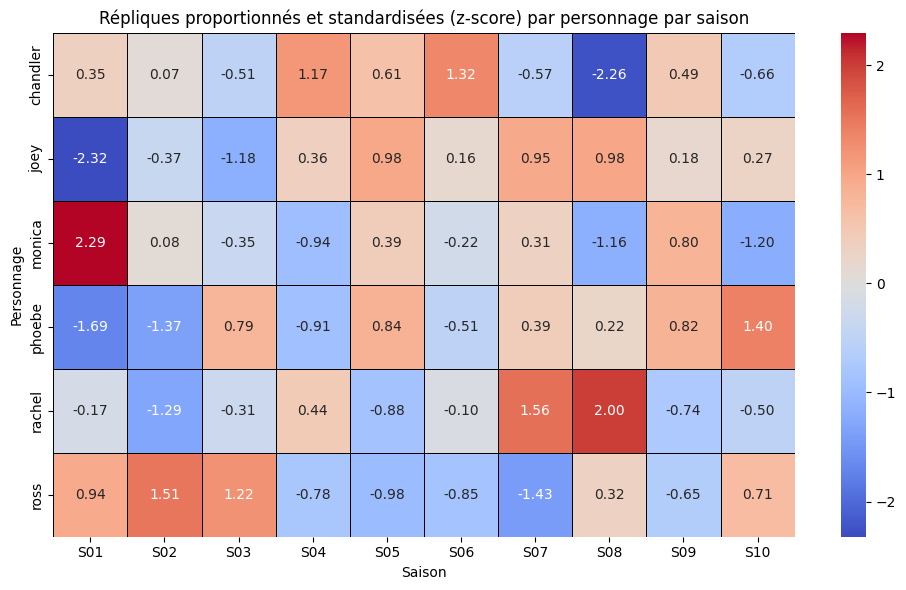

In [23]:
def heatmap_zscores_repliques(filepath):
    # chargement du fichier zscores pré-calculés
    df = pd.read_csv(filepath)

    # heatmap personnage vs saison
    pivot = df.pivot(index='character', columns='season', values='repliques_zscore')

    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, linecolor='black')
    plt.title("Répliques proportionnés et standardisées (z-score) par personnage par saison")
    plt.xlabel("Saison")
    plt.ylabel("Personnage")
    plt.tight_layout()
    plt.show()

heatmap_zscores_repliques("friends_characters_mentions_repliques_zscore.csv")

### Pré-analyse mentions par saison pour chaque persos
*Evolution d'un personnage par rapport à ses autres saisons, pas par rapport aux autres personnages*

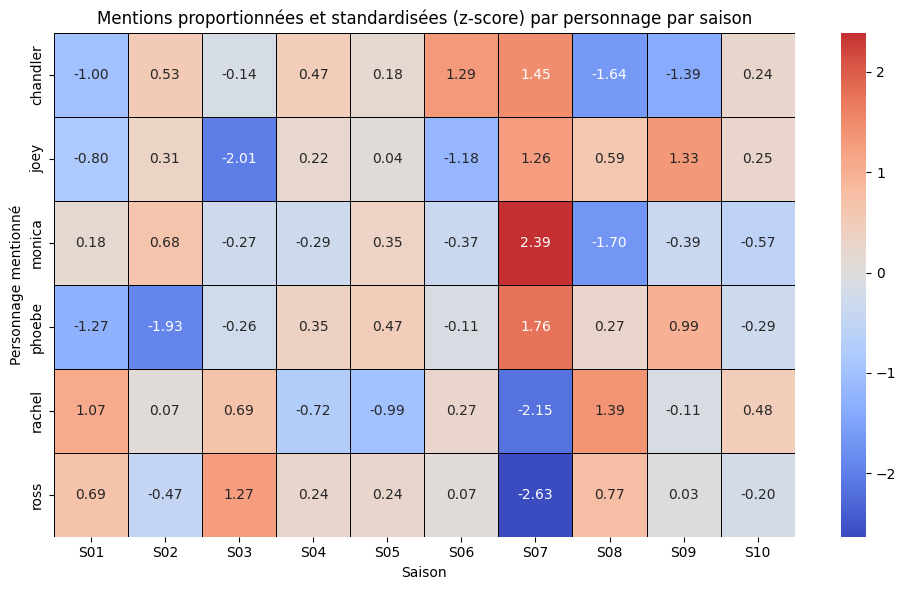

In [24]:
def heatmap_mentions_zscore(filepath):
    df = pd.read_csv(filepath)

    # heatmap personnage vs saison
    pivot = df.pivot(index='character', columns='season', values='mentions_zscore').fillna(0)

    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, annot=True, cmap='coolwarm', center=0, fmt=".2f", linewidths=0.5, linecolor='black')
    plt.title("Mentions proportionnées et standardisées (z-score) par personnage par saison")
    plt.xlabel("Saison")
    plt.ylabel("Personnage mentionné")
    plt.tight_layout()
    plt.show()

heatmap_mentions_zscore("friends_characters_mentions_repliques_zscore.csv")

### Graphe d'analyse de la répartition des répliques et mentions et moyenne des deux par personnage et saison

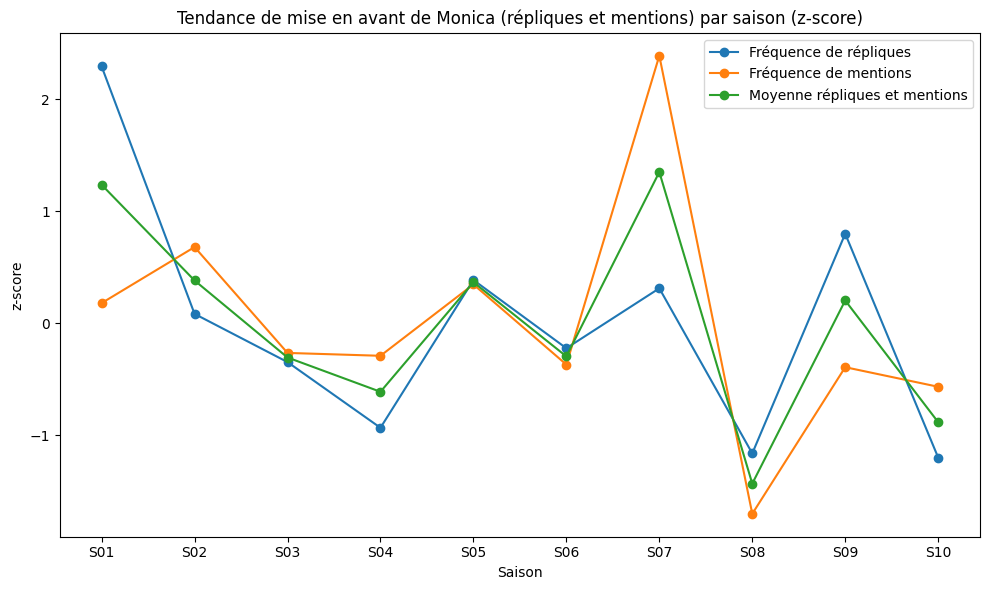

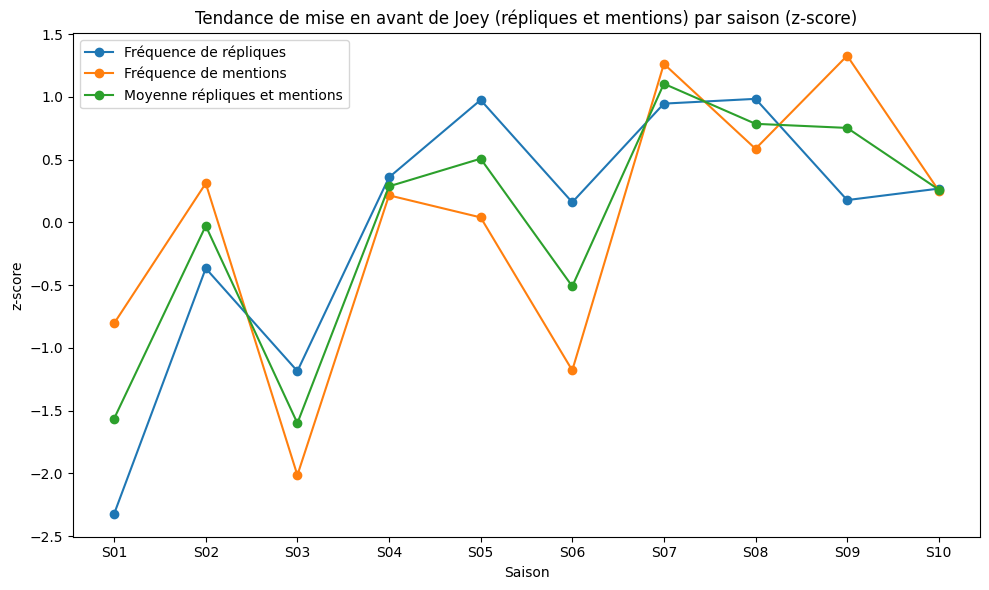

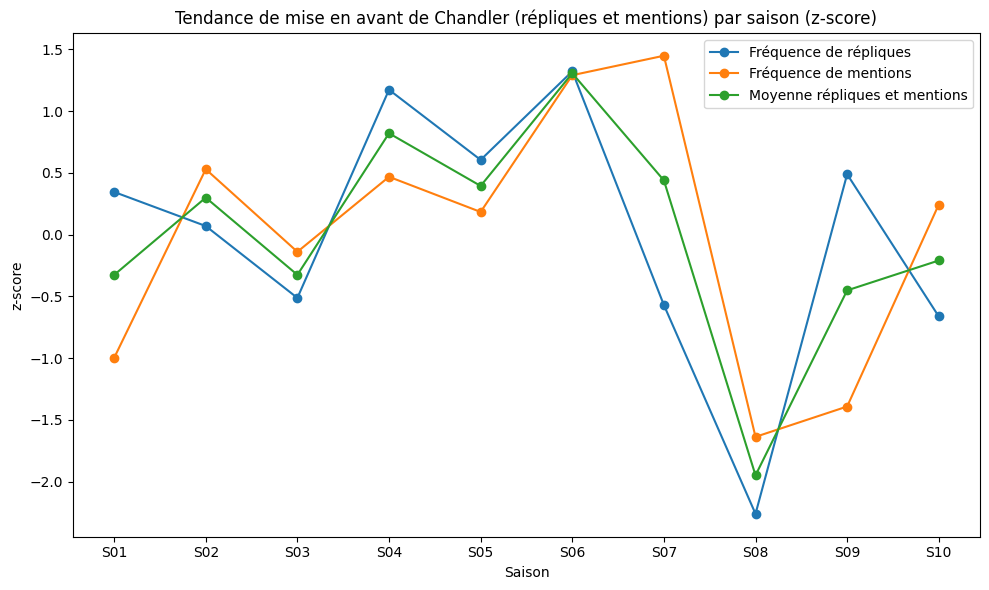

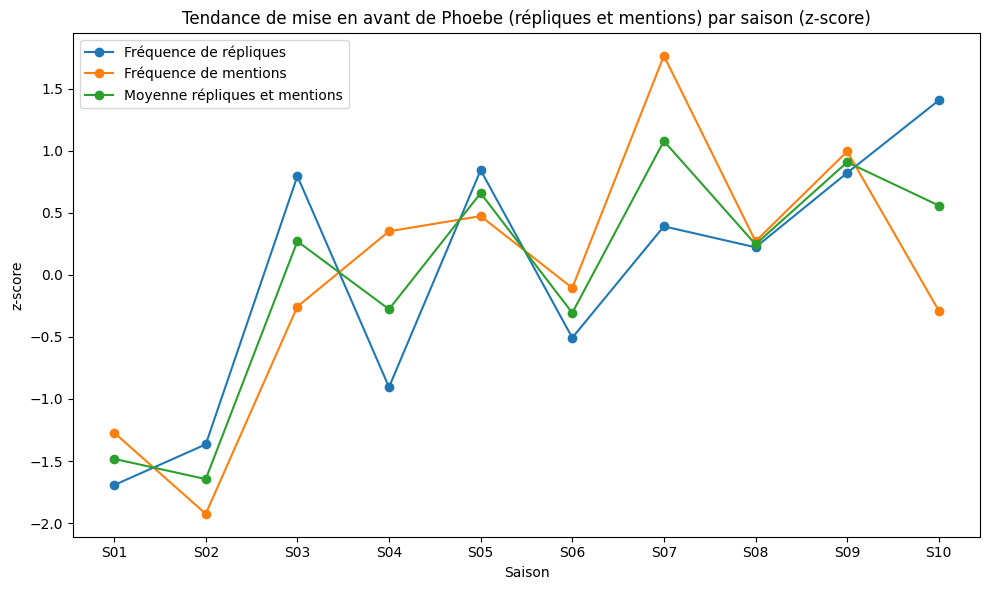

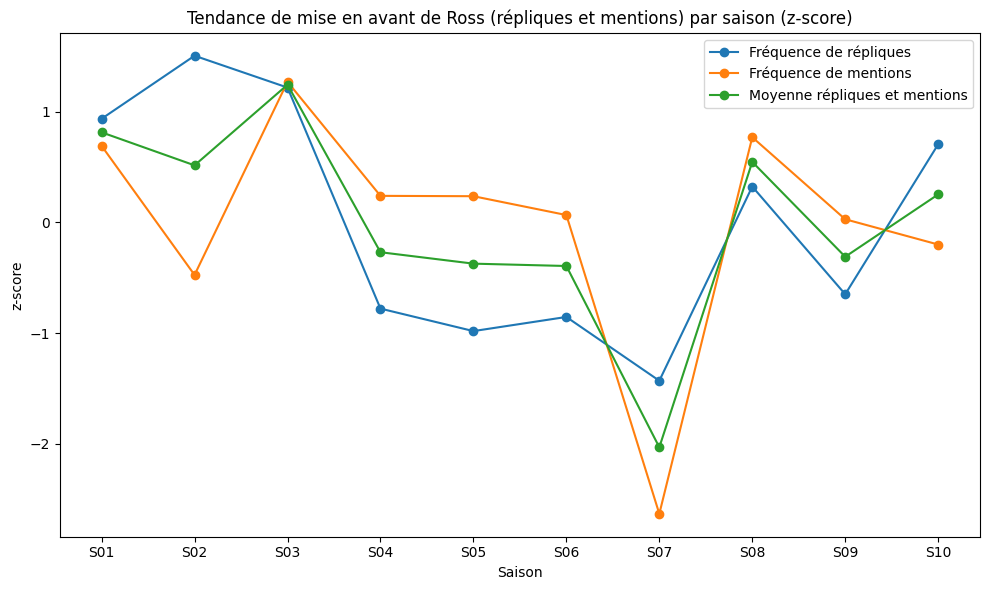

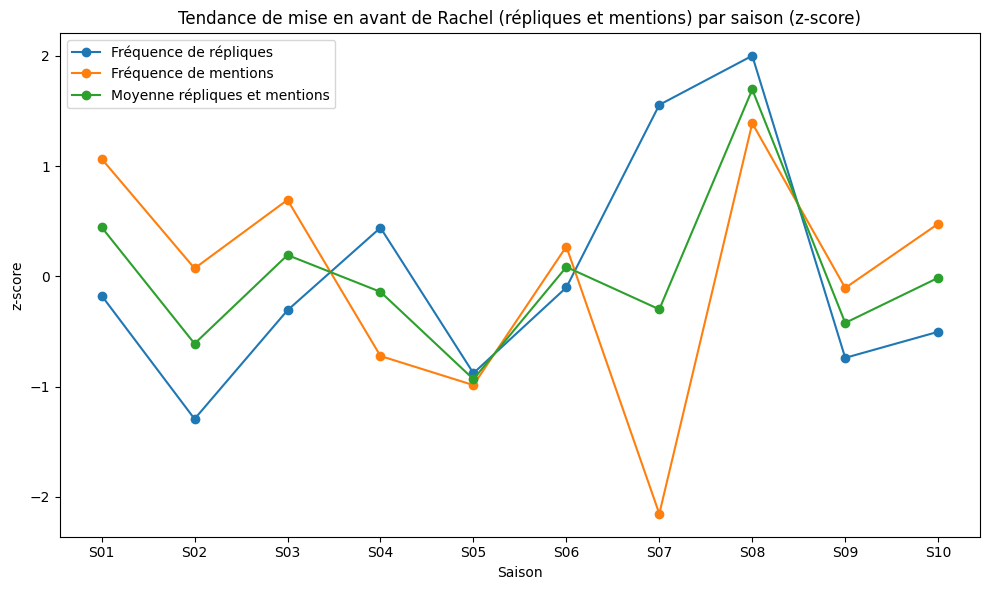

In [25]:
def tracer_tendance_depuis_zscores(filepath):
    """
    Trace la tendance de mise en avant des personnages dans Friends
    en fonction des répliques et des mentions, en utilisant les z-scores.
    """
    df = pd.read_csv(filepath)

    characters = df['character'].unique()

    for character in characters:
        # tri dans l'ordre des saisons
        df_char = df[df['character'] == character].sort_values('season')

        plt.figure(figsize=(10,6))
        plt.title(f"Tendance de mise en avant de {character.capitalize()} (répliques et mentions) par saison (z-score)")
        plt.xlabel("Saison")
        plt.ylabel("z-score")

        # plot des répliques et mentions z-score
        plt.plot(df_char['season'], df_char['repliques_zscore'], marker='o', label='Fréquence de répliques')
        plt.plot(df_char['season'], df_char['mentions_zscore'], marker='o', label='Fréquence de mentions')
        # plot de la moyenne des z-scores
        plt.plot(df_char['season'], df_char['average_zscore'], marker='o', label='Moyenne répliques et mentions')

        plt.legend()
        plt.tight_layout()
        plt.savefig(f"{PATH}/graphe_tendance_mise_en_avant_{character}_par_scenariste.png", dpi=300)
        plt.show()
        plt.close()

# Exemple d’utilisation
tracer_tendance_depuis_zscores("friends_characters_mentions_repliques_zscore.csv")

**Ces données quantitatives sont intéressantes et permettent d'être plus précise qu'une simple fréquence de répliques, et permette d'identifier plusieurs profil, même si rare, parfois un personnage s'éloigne complètement du groupe**

**L'étude `etude_mots_idf` utilise les meilleur saison que l'on trouve dans ces graphes pour observer les tendances de mots caractéristiques**